In [1]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import wandb
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZES = [100, 100]

In [3]:
# reads all images in filepath, resizes it according with 2D list img_sizes and 
# store them in a np_array. The string filepath can only contain images (no other
# file types such as txt for example are allowed). 
# It works only for RGB images.
def images_to_np_array(filepath, img_sizes):
    #-----------------------------------------------------------------------------
    # Args:
    #     filepath:  String with the path to the directory containing the images.
    #                It CANNOT end with the / character.
    #     img_sizes: 2D array [num_rows, num_columns].
    #-----------------------------------------------------------------------------

    # list all files in filepath
    list_of_files = [file for file in os.listdir(filepath)]

    # number of image files
    n_images = len(list_of_files)

    # create np_array to store all images
    array_images = np.zeros([n_images, IMAGE_SIZES[0], IMAGE_SIZES[1], 3])

    for index in range( n_images ):

        # get file name   
        file_name = list_of_files[index]

        # Open the image form working directory
        image = Image.open(filepath + '/' + file_name)

        # resize image
        image_resized = image.resize(IMAGE_SIZES)

        # convert it to numpy
        np_image = np.asarray(image_resized)
        array_images[index,:,:,:] = np_image

    return array_images



In [4]:
# reads multiple folders, each one containing images from one class, divided in a folder containing 
# all training images and another folder containing all test images
def read_folders_multiclass(list_of_folders, img_sizes):
    #-----------------------------------------------------------------------------
    # Args:
    #     list_of_folders:      String with the path to the directories containing 
    #                           the images. Each directory corresponds to a class
    #                           in 2 folders names train and test. Ex.: for k classes,
    #                           list_of_folders = ["dir_class_1", ... "dir_class_k"]
    #                           
    #                           dir_class_1/
    #                                 train/
    #                                 test/
    #                           dir_class_2/
    #                                 train/
    #                                 test/
    #                           .
    #                           .
    #                           .
    #                           dir_class_k/
    #                                 train/
    #                                 test/
    #
    #                           list_of_folders CANNOT end with the / character.
    #
    #     img_sizes: 2D array [num_rows, num_columns].
    #-----------------------------------------------------------------------------

    # number of classes
    n_classes = len(list_of_folders)
    k = 0
    
    # training data
    x_train = images_to_np_array(filepath = list_of_folders[0] + "/train", img_sizes = IMAGE_SIZES)
    y_train = np.zeros(x_train.shape[0])

    # test data
    x_test = images_to_np_array(filepath = list_of_folders[0] + "/test", img_sizes = IMAGE_SIZES)
    y_test = np.zeros(x_test.shape[0])

    for k in range(1, n_classes):
            
        # read train
        x_train_k = images_to_np_array(filepath = list_of_folders[k] + "/train", img_sizes = IMAGE_SIZES)
        y_train_k = np.zeros(x_train_k.shape[0]) + k

        # concatenate X and y with the current vectors
        x_train = np.concatenate( (x_train, x_train_k) )
        y_train = np.concatenate( (y_train, y_train_k) ) 

        # read test
        x_test_k = images_to_np_array(filepath = list_of_folders[k] + "/test", img_sizes = IMAGE_SIZES)
        y_test_k = np.zeros(x_test_k.shape[0]) + k

        # concatenate X and y with the current vectors
        x_test = np.concatenate( (x_test, x_test_k) )
        y_test = np.concatenate( (y_test, y_test_k) ) 


    # shuffle the data
    number_of_images = len(y_train)
    permuted_index = np.random.permutation(number_of_images)

    # training data
    x_train = x_train[permuted_index, :, :, :]
    y_train = y_train[permuted_index]

    return {"x_train": x_train,
            "y_train": y_train,
            "x_test": x_test,
            "y_test": y_test}




In [5]:
# read image data
data_dict = read_folders_multiclass(list_of_folders=["./burro", "./capivara"], img_sizes=IMAGE_SIZES)


In [6]:
# extracting training data
y_train = data_dict["y_train"]
x_train = data_dict["x_train"]

# extracting test data
y_test = data_dict["y_test"]
x_test = data_dict["x_test"]


In [7]:
# preprocessing 
x_train = tf.keras.applications.densenet.preprocess_input(x_train, data_format = "channels_last")
x_test = tf.keras.applications.densenet.preprocess_input(x_test, data_format = "channels_last")


In [8]:

# initialize model with weights treined in imagenet 
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZES[0], IMAGE_SIZES[1], 3),
    pooling="avg",
    classes=2,
    classifier_activation="None"
)

# Freeze model weights
base_model.trainable = False

2022-08-16 16:58:30.854520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 16:58:30.925896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 16:58:30.926104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 16:58:30.926780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.5),]
)

In [10]:
inputs = tf.keras.Input(shape=(IMAGE_SIZES[0], IMAGE_SIZES[1], 3))
# apply data augmentation
x = data_augmentation(inputs)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.Flatten(data_format = "channels_last")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 100)               166500    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100 

In [11]:
#checkpoint_filepath = "./trained_model_checkpoint"

# define the callback (to save the weights that gave best val_accuracy during training)
#callback = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy',
#                                              mode = "max",
#                                              save_best_only = True,
#                                              filepath = checkpoint_filepath)


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

history = model.fit(x = x_train, 
                    y = y_train, 
                    epochs = 50, 
                    validation_data = (x_test, y_test), 
                    batch_size = 100)


Epoch 1/50


2022-08-16 16:58:43.936792: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-16 16:58:45.184371: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/7 [==============================] - 18s 851ms/step - loss: 0.6354 - binary_accuracy: 0.5707 - val_loss: 0.6502 - val_binary_accuracy: 0.7050
Epoch 2/50
7/7 [==============================] - 1s 187ms/step - loss: 0.5486 - binary_accuracy: 0.7039 - val_loss: 0.4927 - val_binary_accuracy: 0.8600
Epoch 3/50
7/7 [==============================] - 1s 181ms/step - loss: 0.4747 - binary_accuracy: 0.7697 - val_loss: 0.3865 - val_binary_accuracy: 0.8850
Epoch 4/50
7/7 [==============================] - 1s 199ms/step - loss: 0.4213 - binary_accuracy: 0.7944 - val_loss: 0.3273 - val_binary_accuracy: 0.9000
Epoch 5/50
7/7 [==============================] - 1s 219ms/step - loss: 0.3832 - binary_accuracy: 0.8043 - val_loss: 0.2837 - val_binary_accuracy: 0.9100
Epoch 6/50
7/7 [==============================] - 1s 190ms/step - loss: 0.3530 - binary_accuracy: 0.7993 - val_loss: 0.2456 - val_binary_accuracy: 0.9200
Epoch 7/50
7/7 [==============================] - 1s 189ms/step - loss: 0.3190 - binar

In [13]:
model.evaluate(y = y_test, x = x_test, verbose = 2)

7/7 - 4s - loss: 0.1324 - binary_accuracy: 0.9550 - 4s/epoch - 638ms/step


[0.13243135809898376, 0.9549999833106995]

In [14]:
predictions = model.predict(x_test)
pd.DataFrame( {"probability": tf.keras.activations.sigmoid(predictions)[:,0], "label": y_test})

7/7 [==============================] - 2s 49ms/step


,probability,label
0,0.000959,0.0
1,0.058081,0.0
2,0.002106,0.0
3,0.021232,0.0
4,0.000800,0.0
...,...,...
195,0.999976,1.0
196,0.999982,1.0
197,0.791209,1.0
198,0.999561,1.0


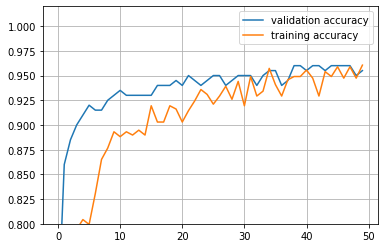

In [15]:
plt.plot( history.history['val_binary_accuracy'], label='validation accuracy')
plt.plot( history.history['binary_accuracy'], label = 'training accuracy')
plt.ylim([0.8, 1.02])
plt.grid()
plt.legend()
plt.show()

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history_2 = model.fit(x = x_train, y = y_train, epochs=epochs, validation_data = (x_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 100)               166500    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100 

2022-08-16 17:00:17.817969: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-16 17:00:17.818158: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-16 17:00:17.835755: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-16 17:00:17.835806: W tensorflow/core/common_runtime/bfc_allocato

19/19 [==============================] - 20s 314ms/step - loss: 0.1056 - binary_accuracy: 0.9523 - val_loss: 0.1247 - val_binary_accuracy: 0.9500
Epoch 2/50
19/19 [==============================] - 4s 212ms/step - loss: 0.1072 - binary_accuracy: 0.9605 - val_loss: 0.1423 - val_binary_accuracy: 0.9550
Epoch 3/50
19/19 [==============================] - 4s 213ms/step - loss: 0.0692 - binary_accuracy: 0.9803 - val_loss: 0.1127 - val_binary_accuracy: 0.9600
Epoch 4/50
19/19 [==============================] - 4s 213ms/step - loss: 0.0601 - binary_accuracy: 0.9803 - val_loss: 0.1022 - val_binary_accuracy: 0.9600
Epoch 5/50
19/19 [==============================] - 4s 214ms/step - loss: 0.0538 - binary_accuracy: 0.9803 - val_loss: 0.1247 - val_binary_accuracy: 0.9500
Epoch 6/50
19/19 [==============================] - 4s 214ms/step - loss: 0.0494 - binary_accuracy: 0.9836 - val_loss: 0.1194 - val_binary_accuracy: 0.9500
Epoch 7/50
19/19 [==============================] - 4s 213ms/step - loss: 

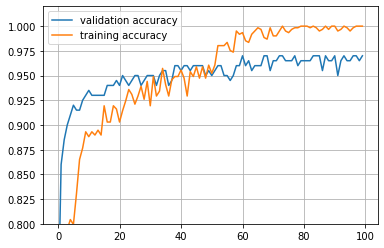

In [17]:

# concatenate results from the 2 training steps
val_acc = np.concatenate( (history.history['val_binary_accuracy'], history_2.history['val_binary_accuracy']) )
acc = np.concatenate( (history.history['binary_accuracy'], history_2.history['binary_accuracy']) )


plt.plot( val_acc, label='validation accuracy')
plt.plot( acc, label = 'training accuracy')
plt.ylim([0.8, 1.02])
plt.grid()
plt.legend()
plt.show()